# Tarea 1 Redes Neuronales Artificiales - 2020-1 

## PREGUNTA 2

Integrantes: Andrea Freire - Francisco Sáez - Yeiniel


Una de las áreas donde las redes neuronales han obtenido desempeños decisivamente superiores al resto de los métodos existentes, al menos en su momento, es en el reconocimiento de imágenes. La capacidad de las redes convolucionaes de aprender y extraer patrones sobre patrones hasta obtener características de alto nivel, representativas de atributos de las imágenes, ha permitido desempeños superiores a los obtenidos por otros métodos de aprendizaje automático o inteligencia aritificial, e incluso en algunos casos al desempeño humano.

Una de las tareas usuales que se pueden resolver con redes neuronales convolucionales es la clasificación de imágenes. Para este punto nos basaremos en un dataset de lenguaje de señas, su descripción detallada se puede encontrar en https://www.kaggle.com/datamunge/sign-language-mnist (No es necesario descargar directamente el dataset si está usando _Colab_ como es sugerido)

<h1 align='center'> <img src="https://i1.wp.com/25.media.tumblr.com/tumblr_mdcs1cF4nn1ri2o31o1_1280.png" width="100%" height="30%" /> </h1>


Note que el entrenamiento de redes convolucionales se beneficia particularmente del uso de unidades de procesamiento gráfico, por lo cual podría ser recomendable utilizarlas en caso de disponer, o considerar correr los codigos completos una vez verificado su funcionamiento en una sesión de Collab acelerada por GPU, entre otras opciones de GPU en la nube existentes.

### 2.a Carga de datos y visualizaciones

I) Iniciaremos cargando los datos. Para esto necesitará crear una cuenta en kaggle, dirigirse a su perfil, ir a Account, y en la sección API apretar _Create new API token_, se descargará un archivo kaggle.json, ábralo como archivo de texto y obtenga su username y key. Luego, ejecute el siguiente código.

In [ ]:
username="franciscosez"
key="5bb9dc443caaff3bb6af9f0237e98a27"
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d datamunge/sign-language-mnist
if not os.path.exists("/content/competitions/data_sign"):
    os.makedirs("/content/competitions/data_sign")
os.chdir('/content/competitions/data_sign')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

 78% 49.0M/62.6M [00:00<00:00, 242MB/s]
100% 62.6M/62.6M [00:00<00:00, 248MB/s]
american_sign_language.PNG  sign-language-mnist.zip  sign_mnist_train
amer_sign2.png		    sign_mnist_test	     sign_mnist_train.csv
amer_sign3.png		    sign_mnist_test.csv


## Paquetes a utilizar

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import History, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.engine import input_layer

In [ ]:
df_tr = pd.read_csv('sign_mnist_train.csv')
X_tmp = df_tr.values[:,1:].reshape(-1,28,28,1)
Y_tmp = df_tr.values[:,:1]

df_tst = pd.read_csv('sign_mnist_test.csv')
X_tst  = df_tst.values[:,1:].reshape(-1,28,28,1)
Y_tst  = df_tst.values[:,:1]

Para evitar largos tiempos de entrenamiento y hacer más desafiante el problema, sacrificaremos data de entrenamiento. **Ejecutar el siguiente código**. Mantendremos el tamaño del conjunto de test.

In [ ]:
sf = StratifiedShuffleSplit(n_splits=1, test_size=2000, random_state=0)

for smaller_index, data_index in sf.split(X_tmp, Y_tmp):
  x_tmp = X_tmp[data_index]
  y_tmp = Y_tmp[data_index]

II) **Visualice** algunas imágenes de cada una de las catégorias junto con sus nombres. 


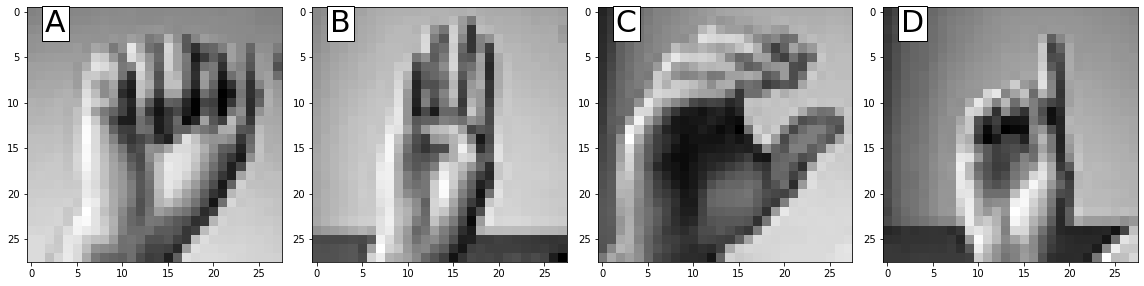

In [ ]:
plt.rcParams["figure.figsize"] = [16,4]
letters = ["A","B","C","D","E","F","G","H","I","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y"]
fig, axs = plt.subplots(1,4)
for i,ax in enumerate(axs):
  ax.imshow(x_tmp[np.where(y_tmp[:,0]==i)[0][0],:,:,0], cmap = 'gray')
  ax.text(1.5,2.2, letters[i], bbox={'facecolor':'white','pad':3},fontsize=30)
plt.tight_layout()
plt.show()

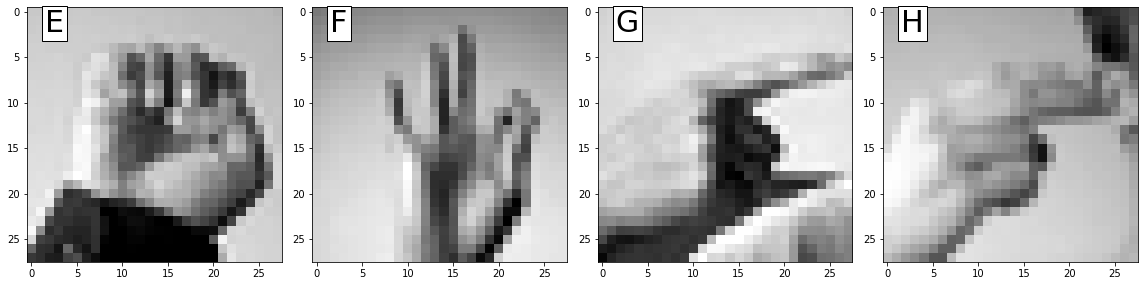

In [ ]:
fig, axs = plt.subplots(1,4)
for i,ax in enumerate(axs):
  ax.imshow(x_tmp[np.where(y_tmp[:,0]==i+4)[0][0],:,:,0], cmap = 'gray')
  ax.text(1.5,2.2, letters[i+4], bbox={'facecolor':'white','pad':3},fontsize=30)
plt.tight_layout()
plt.show()

**Preguntas:** ¿Qué pares de categorías cree podrían ocasionar problemas al momento de clasificación?¿Por qué hay letras omitadas (inferir viendo abecedario de lenguaj de señas americano)?¿Las categorías están balanceadas?¿Cuántos canales están disponibles?

Text(0, 0.5, 'Cantidad por clase normalizada')

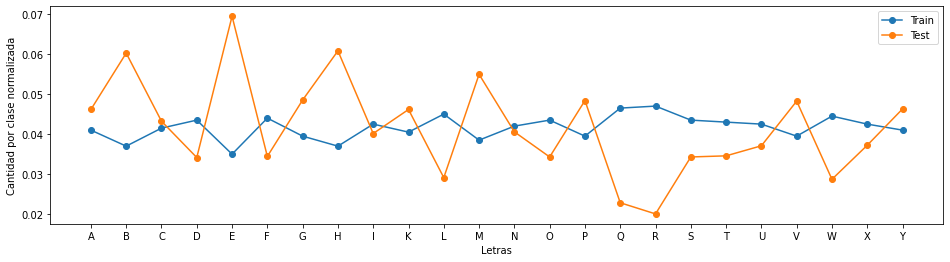

In [ ]:
tr  = np.sum(pd.get_dummies(y_tmp[:,0],len(letters)).values,axis=0)
tst = np.sum(pd.get_dummies(Y_tst[:,0],len(letters)).values,axis=0)

plt.rcParams["figure.figsize"]=[16,4]
plt.plot(letters,tr/np.sum(tr),'-o', label='Train')
plt.plot(letters,tst/np.sum(tst),'-o',label='Test')
plt.legend()
plt.xlabel('Letras')
plt.ylabel('Cantidad por clase normalizada')

**Comentarios**
- Dado que el modelo depende de la calidad de las imágenes, estas no son muy claras. Por esto, se puede ver que la letra A es muy similar a la letra E lo que puede afectar en la clasificación.

- Las imágenes están en escala de grises por lo que solo tienen un solo canal.

- Se puede ver que para el entrenamiento se tiene un balance de clases relativamente aceptable, no así en el caso del test set. 



## 2.b Preprocesamiento

Conforme el conjunto de entrenamiento y validación a partir de x_tmp e y_tmp con proporciones de 80% y 20% respectivamente, preocúpese de que los conjuntos de entrenamientos y validación mantengan la proporción (aprox) para cada clase (mantener equilibrio de clase), inspírese en el código utilizando para reducir la cantidad de datos (sección 2.a). Transforme la escala de las imágenes de [0, 255] a [-1,1]. Utilice la función `get_dummies` de pandas para transformar $y$ a encodding one hot vector.

**Preguntas:** ¿Perderemos información con este preprocesamiento?¿Qué representa cada uno de los valores de la tupla `x_tr.shape`?
¿Podemos considerar los valores de $y$ como valores numéricos o debemos transformarlos de alguna forma?¿Por qué? ¿Cómo se transforma el `.shape` de $y$?

**Comentarios**: 
- no se pierde información en este preprocesamiento, solo se transforma de escala para evitar problemas con los pesos de la red. 
- x_tr tiene la forma (x,y,z,w) donde x representa la cantidad de ejemplos, y y z representan las dimensiones de las imágenes a utilizar y w es la cantida de canales de cada imagen.
- La mejor forma de trabajar el target en este caso es pasarlo a one-hot vector dado que si se escriben de forma numérica de 1 a 24 se le esta diciendo a la red que existe una diferencia numérica entre las clases, lo cual puede traer problemas en la predicción.
- Transformando el target a one-hot vector, este queda con la dimensión (# de ejemplos, 24) donde un ejemplo correspondiente a la letra A tiene la forma [1, 0, 0, ... , 0]

In [ ]:
# Transformación de escala
x_tmp = x_tmp/127.5-1
x_tst = X_tst/127.5-1

# Separar conjuntos
sf2 = StratifiedShuffleSplit(n_splits=1, test_size=400, random_state=0)
for smaller_index, data_index in sf2.split(x_tmp, y_tmp):
  x_tr  = x_tmp[smaller_index]
  y_tr  = y_tmp[smaller_index]
  x_val = x_tmp[data_index]
  y_val = y_tmp[data_index] 

# Transformar y a one hot vector
y_tr  = pd.get_dummies(y_tr[:,0], len(letters)).values
y_val = pd.get_dummies(y_val[:,0], len(letters)).values
y_tst = pd.get_dummies(Y_tst[:,0], len(Y_tst))

In [ ]:
print('Train set:', np.round(x_tr.shape[0]/2000*100,3),'% \n')
print('Validation set:', np.round(x_val.shape[0]/2000*100,3),'%')

Train set: 80.0 % 

Validation set: 20.0 %


## 2.c Primera Red Convolucional

Entrenaremos una primera red convolucional sobre los datos, con la mayoría de los parámetros por defecto. Cree primero la red siguiente la estructura $C\times P\times C\times P \times D$ donde $C$ representa una capa convolucional, $P$ una capa _Max Pooling_ y $D$ una capa densa. Note que antes de la capa densa debe agregar una capa _Flatten_ que transforma los filtros a vectores que luego pueden ser utilizados por la capa densa.

Para los parámetros de las capas, fijaremos ambas capas convolucionales con 128 filtros de $3\times 3$, stride por default, y padding "same" (es decir, agregaremos 0 a los bordes de la imágen de tal manera que se preserve la dimension de la imágen al atravesar la capa; y las capas de _pooling_ tendrán tamaño y _stride_ $2\times 2$, como muentra el código. **Note que a diferencia de la pregunta 1 aprovecharemos al máximo el lenguaje high-level keras.**

Utilice el método `.summary` del modelo para ver la cantidad de parámetros y las dimensiones de los outputs de cada capa (note que cómo en la primera capa especificaremos el `input_shape` podemosllamar el método antes de compilar el modelo o de pasarle datos. **Justifique** el número de parámetros y el _Output Shape_ de cada capa en función de la estructura de la red y lo aprendido en clase.**

**Preguntas**:

¿Por qué la capa de salida debe tener 24 neuronas?¿Qué operación efectúa la activación _SoftMax_?¿Qué representaria en términos del problema el vector de salida de la red?

**Comentarios:** 
- La capa de salida tiene 24 entradas porque el target a estar con variables dummies tiene dimension 24, entonces cada una de las 24 neuronas representan cada una de las clases.
- La función softmax permite que el output de la red se distribuya la probabilidad de acertar cada predicción, normalizando las 24 predicciones hechas por la red y que estas sumen 100%. Así, se logra que solo una neurona de salida tenga mayor probabilidad de pertencer a una clase.
- El vector de salida representa la predicción hecha para cada ejemplo y entrega por ende, un vector de las mismas caracteristicas de y en forma de one-hot vector.

In [ ]:
model = Sequential()

# Primera capa C x P
model.add(Conv2D(filters = 128,
                 kernel_size = (3,3),
                 padding = 'same',
                 activation = 'relu',
                 input_shape = x_tr.shape[1:]))
model.add(MaxPooling2D(pool_size = (2,2)))

# Segunda capa C X P 
model.add(Conv2D(filters = 128,
                 kernel_size = (3,3),
                 padding = 'same',
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa flatten y D
model.add(Flatten())
model.add(Dense(units=24, activation='softmax'))

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                150552    
Total params: 299,416
Trainable params: 299,416
Non-trainable params: 0
__________________________________________________

## 2.d Primer Entrenamiento

I) Compile la red definida en el item anterior. Para esta pregunta puede usar los optimizadores configurados por defecto, y debe usar como _loss Categorical Crossentropy_. 

Entrene la red hasta observar convergencia recuperando su `history`. Grafique como varía el _accuracy_ en entrenamiento y validación a lo largo del aprendizaje. Adicionalmente calcule el _accuracy_ para todo el conjunto de test. Mida igualmente el _categorical accuracy_ como se muestra en el código.

**Preguntas:**
¿Por qué preferimos medir _crossentropy_ y no por ejemplo MSE en este problema?¿Qué valor representa el _accuracy_?¿Le parece buena medida de desempeño para este problema?¿Por qué luego de lograr un accuracy del 100% en el conjunto de entrenamiento siguen actualizándose los pesos de la red?¿A qué corresponde cada valor de la lista que retorna model.evaluate? 

**Comentarios:** 
- En este caso se utiliza una medida de crossentropy por sobre a la de MSE por que es un problema de clasificación y no de regresión.
- El accuracy representa que tan bien fueron hechas las predicciones respecto al target, en el mejor de los casos, cuando la red tenga una buena predicción el accuracy tendra un valor cercano a 1, siendo 1 el valor máximo.
- Para este problema se puede considerar un función de pérdidad adecuada.
- El modelo sigue entrenando dado que considera el error sobre el validation set y como este sigue disminuyendo, el modelo sigue entrenando. 
-  model.evaluate retorna una lista con todos los valores de las métricas que se utilizaron en el entrenamiento del problema, en este caso, retorna la perdida y el accuracy para el train y validation set.

In [ ]:
my_callbacks = [History(),
                EarlyStopping(patience=100, monitor='val_loss',
                              restore_best_weights = True)]
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_tr, y_tr, epochs=20, validation_data=(x_val,y_val),
                    verbose = 0, callbacks = my_callbacks)

acc_tst = model.evaluate(x_tst, y_tst, verbose=0)

Text(0.5, 1.0, 'Loss')

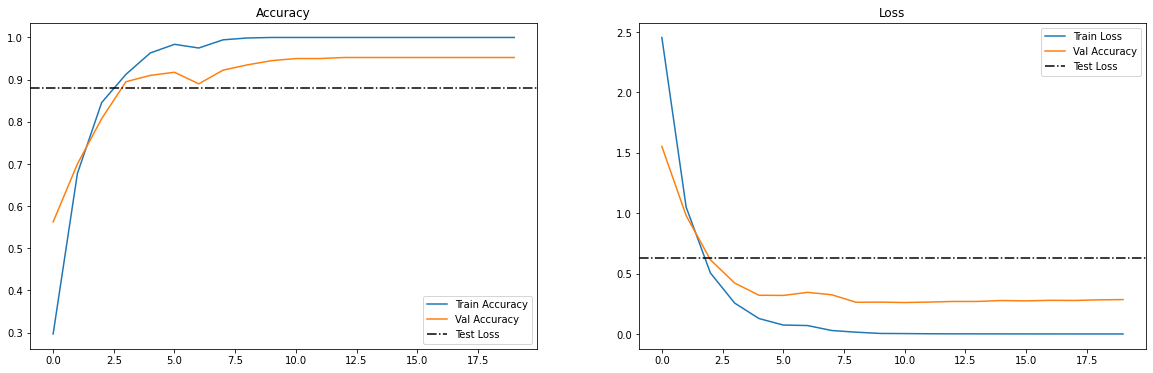

In [ ]:
## Gráficos
plt.rcParams["figure.figsize"] = [20,6]
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.axhline(y = acc_tst[1], color = 'k', linestyle = '-.', label = 'Test Loss')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Accuracy')
plt.axhline(y = acc_tst[0], color = 'k', linestyle = '-.', label = 'Test Loss')
plt.legend()
plt.title('Loss')

Para evitar reentrenar redes al reconectarse, la red neuronal entrenada se puede guardar (arquitectura, pesos y configuración de entrenamiento) del siguiente modo

--> Para verificiar que estamos guardando el modelo correctamente: iniciaremos clonando el modelo, esta función copia la arquitectura del modelo, pero no mentiene los pesos

In [ ]:
model_clone = tf.keras.models.clone_model(model)
[np.all(model_clone.get_weights()[i]==model.get_weights()[i]) for i in range(len(model.get_weights()))]

[False, False, False, False, False, False]

--> Para esto setearemos los pesos del modelo clonado igual a los pesos del modelo original

In [ ]:
model_clone.set_weights(model.get_weights())
[np.all(model_clone.get_weights()[i]==model.get_weights()[i]) for i in range(len(model.get_weights()))]

[True, True, True, True, True, True]

--> Procedemos a guardar el modelo

In [ ]:
import sys
sys.path.append('saved_model')
model.save('saved_model/2_b')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/2_b/assets


In [ ]:
model_new=tf.keras.models.load_model('saved_model/2_b') #<- cargar modelo
[np.all(model_clone.get_weights()[i]==model_new.get_weights()[i]) for i in range(len(model_new.get_weights()))] # <- verificar

[True, True, True, True, True, True]

## 2.e Bloque $C \times C \times P$

Una práctica usal en redes convolucionales es apilar más de un filtro convolucional antes de aplicar _pooling_. La idea detras de esto es darle más "espacio" a la red para aprender los patrones relevantes antes de realizar el subsampleo mediante _pooling_. En el caso de este _dataset_ también nos permite agregar más capas convolucionales sin reducir tan fuertemente las dimensión de las imágenes filtradas. Incluso muchos investigadores optan por agregar más de una capa densa al final de la red, para dar aún más libertad al modelo, pues las restricciones impuestas sobre los parámetros por la estructura convolucional parecieran restringir lo suficiente al modelo, más libertad en las capas finales no pareciera implicar un _overfitting_ tan fuerte como sería por ejemplo en una red _Fully Connected_.

**Cree y entrene** una red, utilizando **dos bloques** de dos capas convolucionales y una de _maxpool_ y luego dos capas densas, es decir, $C\times C\times P \times C\times C\times P\times D \times D$. Utilice $128$ filtros de $3\times 3$ en las dos primeras convoluciones y $64$ filtros $3\times 3$ en las dos siguientes. Para ambas capas de _maxpool_ utilice tamaño y _stride_ $2\times 2$.


**Comente** como se compara el desempeño con la red anterior. Apóyese en gráficos y valores numéricos.

In [ ]:
model = Sequential()

# Primera Capa C x C x P
model.add(Conv2D(filters=128, kernel_size = (3,3), padding='same',
                activation='relu', input_shape=x_tr.shape[1:]))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', 
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Segunda Capa C X C X P
model.add(Conv2D(filters=64, kernel_size = (3,3), padding='same',
                activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', 
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Capa flatten y D x D
model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dense(units = 24, activation='softmax'))

# Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

In [ ]:
# Entrenamiento
my_callbacks = [History(),
                EarlyStopping(patience=100, monitor='val_loss', 
                              restore_best_weights = True)]
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics =['accuracy'])
history2 = model.fit(x_tr,y_tr, epochs=20, 
                     validation_data=(x_val, y_val), verbose =0, callbacks = my_callbacks)

In [ ]:
acc_tst2 = model.evaluate(x_tst, y_tst, verbose=0)

Text(0.5, 1.0, 'Loss')

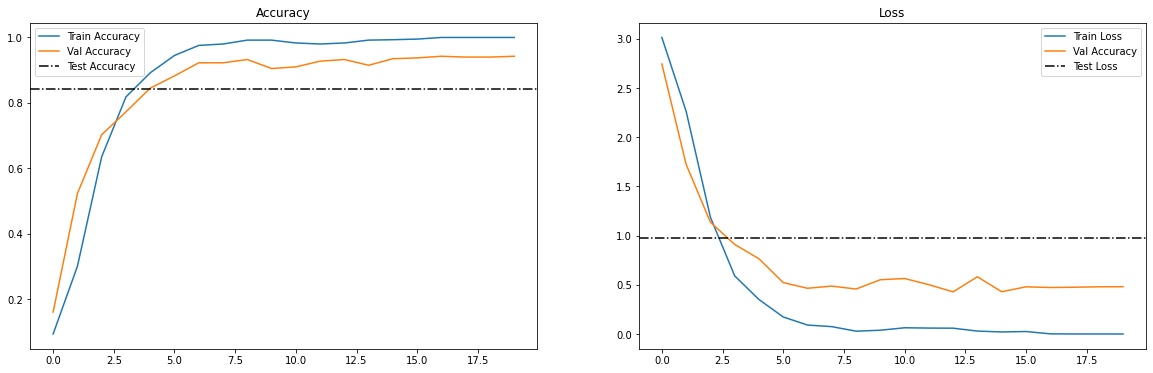

In [ ]:
## Gráficos
plt.rcParams["figure.figsize"] = [20,6]
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label = 'Train Accuracy')
plt.plot(history2.history['val_accuracy'], label = 'Val Accuracy')
plt.axhline(y = acc_tst2[1], color = 'k', linestyle = '-.', label = 'Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label = 'Train Loss')
plt.plot(history2.history['val_loss'], label = 'Val Accuracy')
plt.axhline(y = acc_tst2[0], color = 'k', linestyle = '-.', label = 'Test Loss')
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Loss')

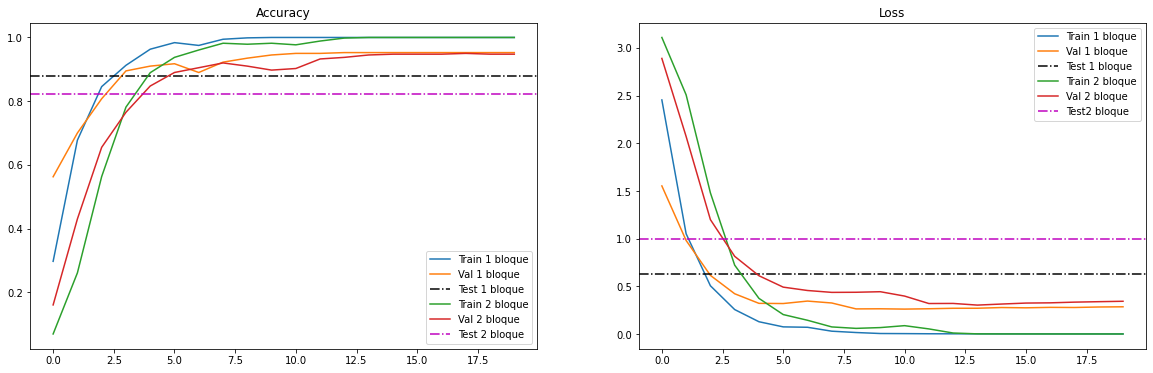

In [ ]:
#Comparación
## Gráficos
plt.rcParams["figure.figsize"] = [20,6]
plt.subplot(1,2,1)
# Red con 1 bloque
plt.plot(history.history['accuracy'], label = 'Train 1 bloque')
plt.plot(history.history['val_accuracy'], label = 'Val 1 bloque')
plt.axhline(y = acc_tst[1], color = 'k', linestyle = '-.', label = 'Test 1 bloque')
# Red con 2 bloque
plt.plot(history2.history['accuracy'], label = 'Train 2 bloque')
plt.plot(history2.history['val_accuracy'], label = 'Val 2 bloque')
plt.axhline(y = acc_tst2[1], color = 'm', linestyle = '-.', label = 'Test 2 bloque')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
# Red con 1 bloque
plt.plot(history.history['loss'], label = 'Train 1 bloque')
plt.plot(history.history['val_loss'], label = 'Val 1 bloque')
plt.axhline(y = acc_tst[0], color = 'k', linestyle = '-.', label = 'Test 1 bloque')
# Red con 2 bloque
plt.plot(history2.history['loss'], label = 'Train 2 bloque')
plt.plot(history2.history['val_loss'], label = 'Val 2 bloque')
plt.axhline(y = acc_tst2[0], color = 'm', linestyle = '-.', label = 'Test2 bloque')
plt.legend()
plt.title('Loss')

**Comentarios:** se puede ver que el desempeño para ambos bloques es relativamente similar. Por el data set a utilizar, este resultado varia cada vez que se itera el modelo. Se puede apreciar que al pasar las 20 epochs ambos modelos, tanto el de 1 bloque como el de 2, tienen resultados muy similares.

## 2.f Exploración de Profundidad

Por comidad preferiremos quedarnos con la estructura en bloques del ítem anterior. En esta pregunta deberán explorar qué ocurre a medida uno cambia la profundidad de la red. Para esto, entrene redes con distintos números de bloques. Debe a lo menos entrenar una red por cada número de bloques entre 1 y 5 bloques (**¿Qué particularidad tiene la red con 5 bloques?¿Puede entrenar una más profunda?**). También entrenar una red con "0" bloques, es decir, una red densa como las de la pregunta 1.

Comente sobre los casos extremos (0 y 5 bloques), ya sea a partir de lo aprendido en clases o lo que observa al momento de entrenar las redes. **¿Le parece que alguno de los dos sea buena aproximación para reconocimiento de imágenes?** para cada red recupere `history` y grafique el valor del mejor _accuracy_ en validación y el _accuracy_ sobre entrenamiento en el mismo _epoch_ en función de la profundidad de la red, similar al procedimiento realizado en 1.c.

Quedan a su discreción los parámetros de cada capa convolucional, puede utilizar el número de filtros que estime convenientes, utilice _stride_ por default, y en caso de utilizar alguna regla para el número de filtros, que tal regla sea la misma para todas las profundidades (pueden ver dos posibles ejemplos en el código propuesto abajo). Para las capas de _MaxPool_ utilicen las que aparecen en el código.

Para ahorra tiempo, si observa que una red no converge, puede detener anticipadamente el entrenamiento. Para esto es recomendable usar el _Callback_ de keras `EarlyStopping` el cual deben agregar al momento de utilizar el método `.fit`, sin embargo asegúrese de ponerle _patience_ de a lo menos 10, pues como podrán observar algunas redes empeoran su desempeño en algunas _epochs_ para lugar seguir mejorando. 

**Comentarios:**

- La red con 5 bloques tiene la particularidad de tener muchos hiperparámetros debido a los 5 bloques de capas convoluciones, esto hace que luego los features maps obtenidos con estos 5 bloques cada vez sean más chicos.
- Se puede seguir entrenando utilizando padding='same', pero no es recomendable.
- Tanto para 0 como para 5 bloques, no parece ser recomendado dado que son los extremos, es decir, en la primeera no tienen bloques por ende no se aplica el proceso de convolución y en la segunda tiene muchos bloques.

In [ ]:
resultados = []

for block_num in range(6):

  model = Sequential()
  print('Entrenando red con: ', block_num,'bloques \n')

  for i in range(block_num+1):
    
    if block_num != 0: 
      if i == 0:
        model.add(Conv2D(128, (3,3), padding='same', activation='relu', input_shape=x_tr.shape[1:]))
        model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
      else:
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    else:
      model.add(Flatten())
      model.add(Dense(x_tr.shape[1]**2, activation='relu'))
  
  # ültima Capa
  model.add(Flatten())
  model.add(Dense(units=24, activation='softmax'))

  # Early Stopping y Compile
  my_callbacks = [History(),EarlyStopping(patience=10,
                                          monitor="val_loss", restore_best_weights=True)]
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

  # Ajuste
  if block_num != 0:
    history = model.fit(x_tr, y_tr, epochs=20, validation_data=(x_val,y_val),
                        verbose=0)
    resultados.append([block_num,history.history])
  else:
    history = model.fit(x_tr, y_tr, epochs=20,
                        validation_data=(x_val,y_val),verbose=0)#,callbacks=mycallbacks)
    resultados.append([block_num,history.history])

Entrenando red con:  0 bloques 

Entrenando red con:  1 bloques 

Entrenando red con:  2 bloques 

Entrenando red con:  3 bloques 

Entrenando red con:  4 bloques 

Entrenando red con:  5 bloques 



Text(0.5, 1.0, 'Val Accuracy')

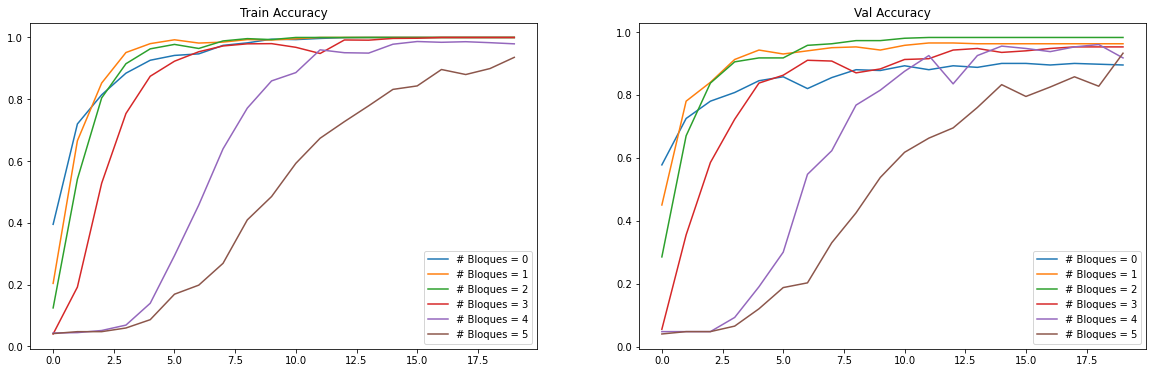

In [ ]:
## Gráficos
plt.rcParams["figure.figsize"] = [20,6]
plt.subplot(1,2,1)
for i in range(6):
  plt.plot(resultados[i][1]['acc'], label = '# Bloques = '+str(resultados[i][0]))
plt.legend()
plt.title('Train Accuracy')

plt.subplot(1,2,2)
for i in range(6):
  plt.plot(resultados[i][1]['val_acc'], label = '# Bloques = '+str(resultados[i][0]))
plt.legend()
plt.title('Val Accuracy')

Text(0.5, 1.0, 'Val Loss')

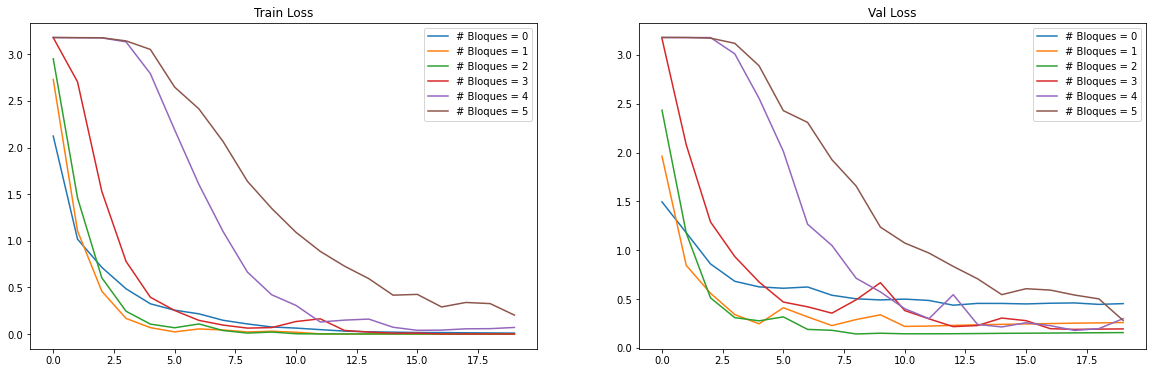

In [ ]:
## Gráficos
plt.rcParams["figure.figsize"] = [20,6]
plt.subplot(1,2,1)
for i in range(6):
  plt.plot(resultados[i][1]['loss'], label = '# Bloques = '+str(resultados[i][0]))
plt.legend()
plt.title('Train Loss')

plt.subplot(1,2,2)
for i in range(6):
  plt.plot(resultados[i][1]['val_loss'], label = '# Bloques = '+str(resultados[i][0]))
plt.legend()
plt.title('Val Loss')

In [ ]:
error = float('inf')

for i in resultados:
  if error > np.min(i[1]['val_loss']):
    error  = np.min(i[1]['val_loss'])
    bloque = i[0]
  
print('El bloque con menor error de validación es: ', bloque, 'con error igual a:',np.round(error,3))

El bloque con menor error de validación es:  2 con error igual a: 0.143


**Comentarios:** se puede ver que la mejor arquitectura corresponde al caso con los dos bloques y no a los extremos de 0 o 5 bloques.

## 2.g Exploración libre

Como probablemente ya habrán notado, la cantidad de hiperparámetros que se pueden fijar y explorar en una red convolucional es enorme. A parte de poder modificar la arquitectura de la red y su tamaño o profundidad, pueden en cada una de las capas modificar el número de filtros, el tamaño de los filtros, modificar _stride_, cambiar las activaciones, cambiar el _padding_, cambiar los tamaños de los _MaxPool_ o sus _strides_ o incluso modificar las capas densas al final de la red.

Por mitivos de tiempo y con la esperanza de que la tarea no sea más tediosa de lo necesario, en vez de pedir explorar cada uno de estos parámetros, se les propone elegir una exploración de la siguiente lista. Debe realizar la exploración exahustivamente, comentar los resultados apoyándose de gráficos y su conocimiento teórico cuando sea apropiado. Independiente de la exploración elegida debe responder las preguntas finales.

Para todas las exploraciones utilice como _template_ la mejor red entrada hasta ahora y modifique el parámetro relevante.

**Exploraciones posibles (Elija 1)**
* Tamaño de los filtros: Manteniendo el filtro cuadrado, explore cambiar el tamaño de filtro de alguna(s) capas convolucionales. Debe explorar a lo menos valores de $1\times 1$ hasta $9\times 9$, por lo cual debe asegurarse realizar la exploración en una capa donde las dimensiones de los filtros de la capa anterior (o el Input de la capa) se lo permita. 
* Exploración del número de filtros: Explore variando el número de filtros de alguna(s) capas. Se recomienda explorar en potencias de 2, y debe explorar a lo menos 10 valores distintos.
* Neuronas capa Densa: realice una exploración del número de neuronas de alguna o ambas de las capas densas. Debe explorar a lo menos 10 combinaciones distintas. Puede dejar una de las dos capas fijas y variar la otra siguiendo potencias de 2 por ejemplo. Tenga cuidado con la explosión del número de parámetros. 
* Pooling: Pruebe cambiar el tamaño de los _MaxPool_ entre $2\times 2$ a $6\times 6$. Pruebe también cambiando todas las capas por `AveragePooling2D`, realizando la misma exploración que con _MaxPool_.
* Pooling "convolucional": Una aproximación posible para reemplazar las capas de _maxpool_ es utilizando capas convolucionales con kernel $2\times 2$ y _stride_ $2\times 2$. Pruebe reemplazando las capas _maxpool_ por este tipo de capas, luego pruebe una mezcla de ambas, luego pruebe simplemente eliminando las capas de _pooling_ y agregandole _stride_ a la segunda capa de cada bloque (con _kernel size_ $2\times 2$ y $3 \times 3$). Pruebe finalmente cambiando las funciones de activación de las capas donde se realiza la disminución de dimensión, probando a lo menos activación lineal, sigmoidea y tangente hiperbólica.

**Preguntas (responder todas)**:
* ¿A que equivaldría utilizar tamaño de kernel $1 \times 1$?
* ¿Por qué si cambiamos el número de filtros de una capa también modificamos el número de parámetros de la siguiente capa?
* ¿En su opinión, qué metodo resume mejor la información de una capa, _maxpool_ o _averagepool_?
* ¿Qué tipo de patrones esperaría usted que se extraigan mejor con un kernel no cuadrado (por ejemplo $3\times 2$)? Apoyese de un ejemplo pequeño o una explique el fenómeno llevandolo al "extremo" (e.g. $1\times 3$)


**Respuestas:**
- utilizar un kernel de 1x1 equivale a multiplicar cada entrada por un mismo valor (escalar) dado que no existe el proceso de convolución entre pixeles cercanos en la imágenes.
- Si se cambia el número de filtros se estará cambiando la cantidad de kernel a utilizar por lo tanto se aumentan los pesos a entrenar. De la misma forma, eso provoca que se modifiquen los parámetros de las otras capas ya que afecta al modelo en general.
- En la experiencia que se ha tenido con las redes neuronales, el más utilizado corresponde a maxpool, dado que al trabajar con imágenes en escalas de grises, este mantiene los pixeles de intensidad más elevada.
- Al cambiar la configuración del kernel se puede combinar la información de otra forma, por ejemplo en el caso de tener un kernel no cuadrado, a medida que barre el lado más grande del kernel, este considerará más los atributos en esa dirección.

In [ ]:
results = []
n_filters = [2,4,8,16,32,64,128,256,512,1024]

for i in n_filters:

  model = Sequential()

  # Primera capa
  model.add(Conv2D(filters=i, kernel_size = (3,3), padding='same',
                  activation='relu', input_shape=x_tr.shape[1:]))
  model.add(Conv2D(filters=i, kernel_size=(3,3), padding= 'same', 
                  activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Segunda Capa 
  model.add(Conv2D(filters=i, kernel_size = (3,3), padding='same',
                  activation='relu'))
  model.add(Conv2D(filters=i, kernel_size=(3,3), padding= 'same', 
                  activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Output
  model.add(Flatten())
  model.add(Dense(24, activation='relu'))
  model.add(Dense(units = 24, activation='softmax'))

  my_callbacks = [History(),
                  EarlyStopping(patience=10,monitor="val_loss", restore_best_weights=True)]
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

  history = model.fit(x_tr, y_tr, epochs=20, validation_data=(x_val,y_val),
                        verbose=0, callbacks = my_callbacks)
  results.append([i,history.history])
  print('Filters: ',i,' listo!' )

Filters:  2  listo!
Filters:  4  listo!
Filters:  8  listo!
Filters:  16  listo!
Filters:  32  listo!
Filters:  64  listo!
Filters:  128  listo!
Filters:  256  listo!
Filters:  512  listo!
Filters:  1024  listo!


Text(0.5, 1.0, 'Val Accuracy')

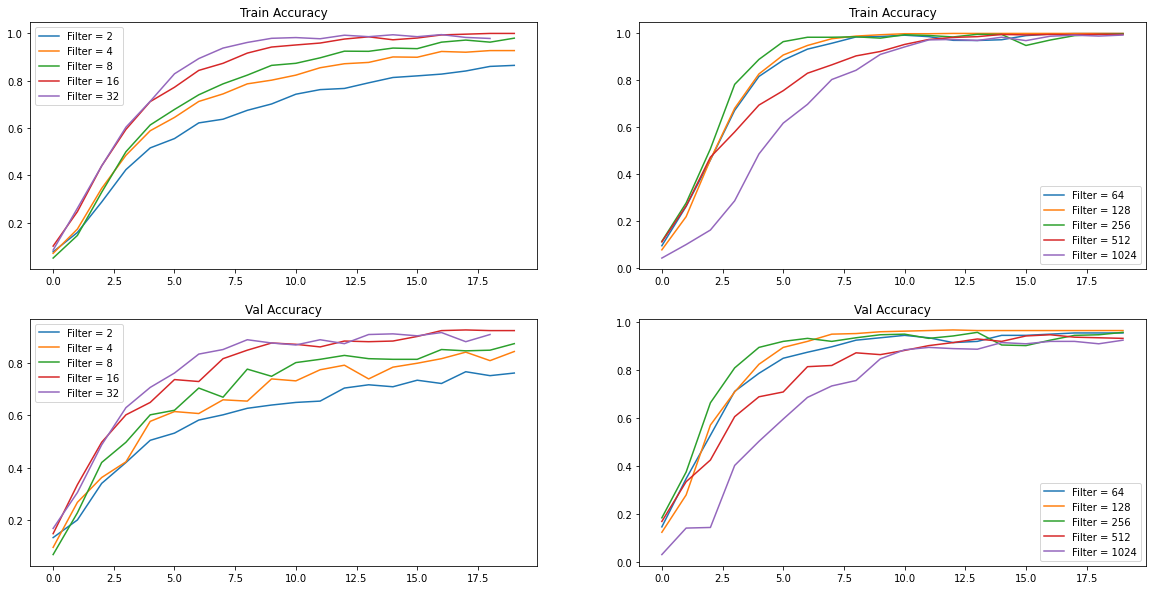

In [ ]:
## Gráficos
plt.rcParams["figure.figsize"] = [20,10]
plt.subplot(2,2,1)
for i in range(5):
  plt.plot(results[i][1]['acc'], label = 'Filter = '+str(n_filters[i]))
plt.legend()
plt.title('Train Accuracy')

plt.subplot(2,2,3)
for i in range(5):
  plt.plot(results[i][1]['val_acc'], label = 'Filter = '+str(n_filters[i]))
plt.legend()
plt.title('Val Accuracy')

plt.subplot(2,2,2)
for i in range(5,10):
  plt.plot(results[i][1]['acc'], label = 'Filter = '+str(n_filters[i]))
plt.legend()
plt.title('Train Accuracy')

plt.subplot(2,2,4)
for i in range(5,10):
  plt.plot(results[i][1]['val_acc'], label = 'Filter = '+str(n_filters[i]))
plt.legend()
plt.title('Val Accuracy')

Text(0.5, 1.0, 'Val Loss')

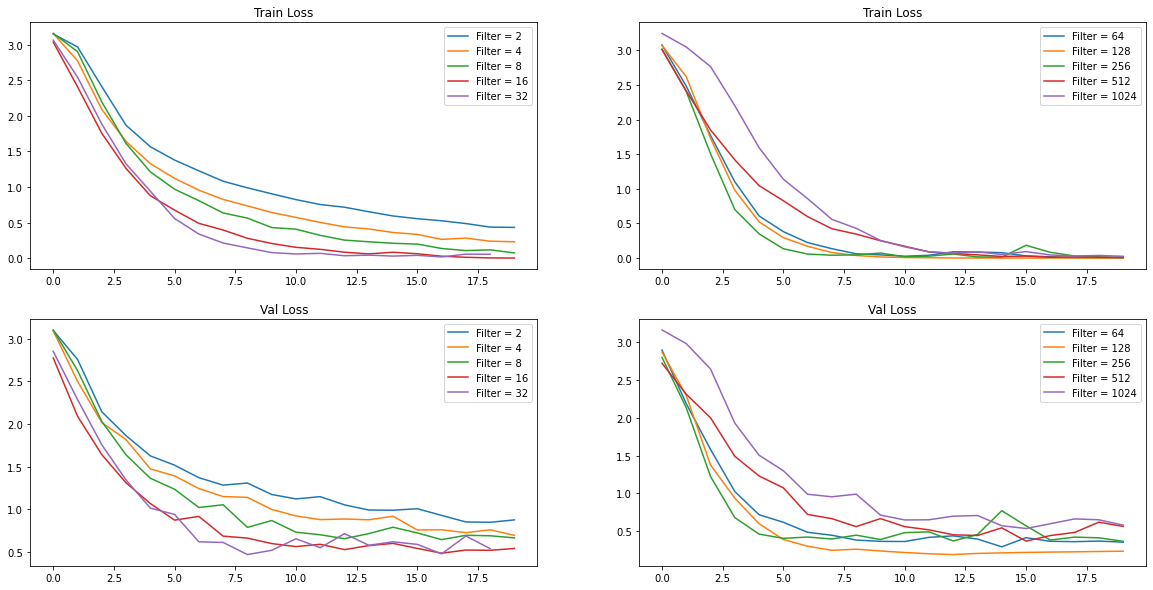

In [ ]:
## Gráficos
plt.rcParams["figure.figsize"] = [20,10]
plt.subplot(2,2,1)
for i in range(5):
  plt.plot(results[i][1]['loss'], label = 'Filter = '+str(n_filters[i]))
plt.legend()
plt.title('Train Loss')

plt.subplot(2,2,3)
for i in range(5):
  plt.plot(results[i][1]['val_loss'], label = 'Filter = '+str(n_filters[i]))
plt.legend()
plt.title('Val Loss')

plt.subplot(2,2,2)
for i in range(5,10):
  plt.plot(results[i][1]['loss'], label = 'Filter = '+str(n_filters[i]))
plt.legend()
plt.title('Train Loss')

plt.subplot(2,2,4)
for i in range(5,10):
  plt.plot(results[i][1]['val_loss'], label = 'Filter = '+str(n_filters[i]))
plt.legend()
plt.title('Val Loss')

In [ ]:
error = float('inf')

for i in results:
  if error > np.min(i[1]['val_loss']):
    error  = np.min(i[1]['val_loss'])
    filtro = i[0]
  
print('El filtro con menor error de validación es: ', filtro, 'con error igual a:',np.round(error,3))

El filtro con menor error de validación es:  128 con error igual a: 0.188


## 2.h Data Augmentation

Otra manera de evitar sobreajuste y mejorar los desempeños de una red convolucional es usar aumentación de datos (Ignore el hecho de que botamos datos al inicio). La idea detrás de este método es un hecho muy simple: si rotamos ligeramente una foto por ejemplo de un caballo, seguirá siendo de un caballo. Lo mismo si la movemos ligeramente hacia algun lado, hacia arriba, etc.

Keras trae implementado un generador de imágenes aumentadas, puede basarse en el código abajo para utililzarlo, aunque si lo desea o estima conveniente puede cambiar algunos de los parámetros. Entrene a completitud la mejor red que obtuvo a lo largo de toda la tarea.

**Pregunta:**
¿Qué tanto mejora el desempeño de la red utilizando aumentación de datos?

Basándose en el abecedario de lenguaje de señas que disponemos, ¿Cree que resultará beneficioso o contraproducente realizar _flips_ horizontales y/o verticales?

**Comentarios:** en este caso en particular no afecta mucho aumentar los datos, dado que las imágenes no son de muy buena calidad y puede confundir más aún al modelo. Por otro lado, se cree que puede ser contraproducente utilizar flips en esta imágenes dado que por la forma de las manos para una respectiva letra, está puede al rotar se puede confundir con otra forma.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_tr)

In [ ]:
# Arquitectura

model = Sequential()

# Primera capa
model.add(Conv2D(filters=64, kernel_size = (3,3), padding='same',
                activation='relu', input_shape=x_tr.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', 
                activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Segunda Capa 
model.add(Conv2D(filters=64, kernel_size = (3,3), padding='same',
                activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', 
                activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Output
model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dense(units = 24, activation='softmax'))

my_callbacks = [History(),
                EarlyStopping(patience=10,monitor="val_loss", restore_best_weights=True)]
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

history =  model.fit_generator(datagen.flow(x_tr, y_tr, batch_size=32),
                    epochs=20,
                    verbose=0,
                    callbacks=[EarlyStopping(patience=5)],
                    validation_data=(x_val,y_val),
                    validation_freq=1,
                    shuffle=True)

In [ ]:
acc_tst_2h = model.evaluate(x_tst, y_tst, verbose=0)

Text(0.5, 1.0, 'Loss')

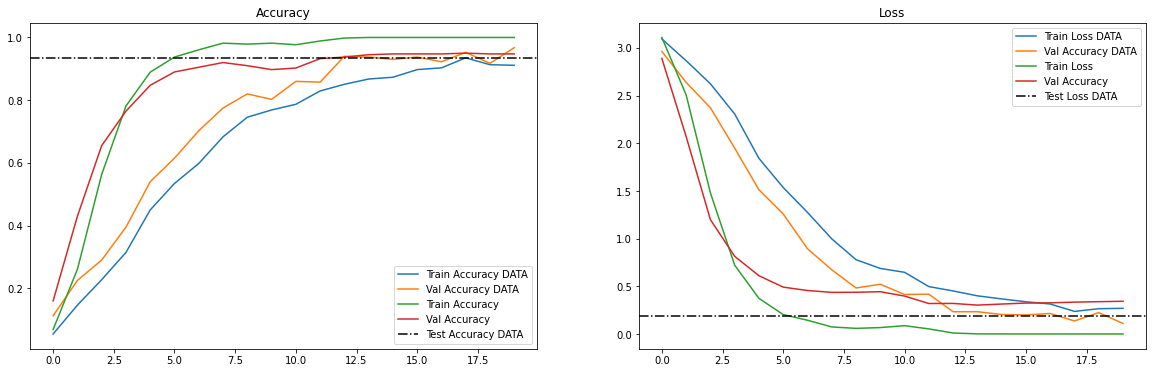

In [ ]:
## Gráficos
plt.rcParams["figure.figsize"] = [20,6]
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label = 'Train Accuracy DATA')
plt.plot(history.history['val_acc'], label = 'Val Accuracy DATA')
plt.plot(history2.history['accuracy'], label = 'Train Accuracy')
plt.plot(history2.history['val_accuracy'], label = 'Val Accuracy')
plt.axhline(y = acc_tst_2h[1], color = 'k', linestyle = '-.', label = 'Test Accuracy DATA')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Train Loss DATA')
plt.plot(history.history['val_loss'], label = 'Val Accuracy DATA')
plt.plot(history2.history['loss'], label = 'Train Loss')
plt.plot(history2.history['val_loss'], label = 'Val Accuracy')
plt.axhline(y = acc_tst_2h[0], color = 'k', linestyle = '-.', label = 'Test Loss DATA')
plt.legend()
plt.title('Loss')

## 2.i Matriz de Confusión

Si bien el _accuracy_ nos ha acompañado toda la pregunta para evaluar el desempeño de nuestras redes de forma fácilmente interpretable, no considera por ejemplo si una gran parte de los errores provienen de una sola clase o si alguna clase se logra clasificar perfectamente. Una manera de visualizar fácilmente esta métrica más granular, es utilizando la matriz de confusión. Investigue y explique brevemente en qué consiste una matriz de confusión (puede explicar el caso binario donde solo hay dos clases). 

Luego, apoyándose en los códigos de abajo, visualizaremos la matriz de confusión del modelo que mejor se desempeñó a lo largo de toda la tarea.

- ¿Algo le llama la atención?
- ¿Qué clase se confunde más entre si?
- ¿Coincidió esto con sus predicciones al inicio de la tarea?

Igual de la misma forma que en 2.a, visualice algunas imágenes mal clasificadas por su modelo. 

- ¿Le parece razonable que el modelo no las clasifique bien?

**Comentarios:**
- De esto llama la atención que la mayoria de las clases si fueron clasificadas de forma correcta , pero aún asi, existen casos donde no se logro en su totalidad. Esto puede ser por la poca claridad de la forma de la mano para cada letra respectivamente.
- Por ejemplo, viendo las imágenes de abajo, se puede ver que existe una gran relación entre la forma de la mano para decir la letra A como la letra N, esto puede generar confusión a la hora de entrenar la red. 
- La predicción de cierta forma si coincidió, pero gracias a que la red de todas formas si puedo hacer una buena predicción, no se encontraron tantas predicciones mal hechas.
- En los pocos casos, donde la red no clasificó de buena forma, es totalmente razonable.

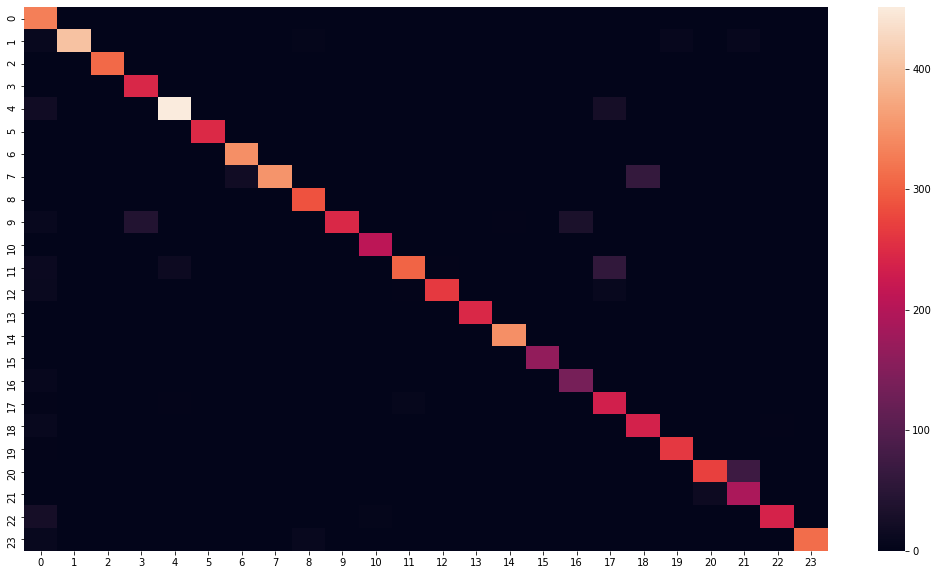

In [ ]:
plt.rcParams["figure.figsize"]=[18,10]
sns.heatmap(confusion_matrix(y_tst.values.argmax(axis=1),
                             pd.DataFrame(np.round(model.predict(x_tst),0)).values.argmax(axis=1)),cbar=True)

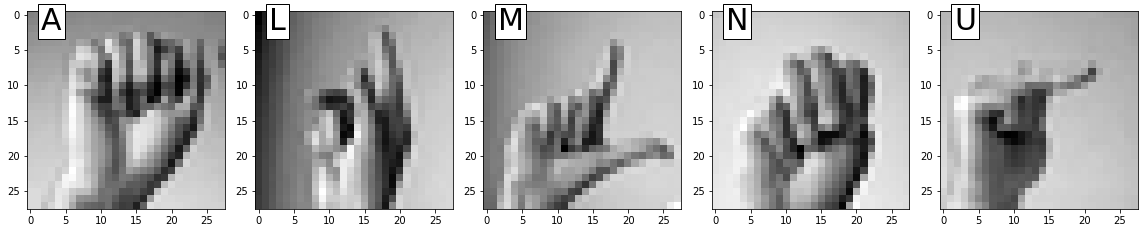

In [ ]:
plt.rcParams["figure.figsize"] = [16,4]
letters = ["A","B","C","D","E","F","G","H","I","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y"]
fail    = [0,10,11,12,19]
fig, axs = plt.subplots(1,5)
for i,ax in enumerate(axs):
  j = fail[i]
  ax.imshow(x_tmp[np.where(y_tmp[:,0]==j)[0][0],:,:,0], cmap = 'gray')
  ax.text(1.5,2.2, letters[j], bbox={'facecolor':'white','pad':3},fontsize=30)
plt.tight_layout()
plt.show()

## 2.j Batch Normalization

Una manera propuesta de mejorar los desempeños de las redes en general, que funciona bastante bien en tareas de reconocimiento de imágenes es _Batch Normalization_. Entrene nuevamente su red preferida de la pregunta anterior, agregando capas de _Batch Normalization_ luego cada capa de _MaxPool_. Comente sus resultados.

**Pregunta** 

Según su conocimiento teórico e investigación. ¿Qué realiza _Batch Normalization_ en términos matemáticos? En términos de aprendizaje. ¿Qué evita la utilización de _Batch Normalization_?

¿Mejoran los desempeños de la red agregando _Batch Normalization?¿Existe diferencias entre una capa de _Batch Normalization_ justo antes o justo después de una capa de _MaxPool_ en términos numéricos?¿Opina lo mismo en términos de aprendizaje? Discuta.

**Comentarios:** 
-  Batch Normalization tiene la función de normalizar las capas antes de la función de activación para mantener la distribución de los atributos en cada capa del respectivo modelo. Esto evita que la red caiga en un problema con el gradiente, ya sea que se desvanezca o que explote.
- Se ve una mejora a la hora de aplicar batch normalization incluso para epochs bien tempranas ya se alcanza buenos resultados.
- Existe una gran diferencia al utilizar batch normalization antes y despues de la capa de maxpool, dado que esta reduce la cantidad de neuronas. Esto se puede ver en los gráficos de abajo.

In [ ]:
# BATCH NORMALIZATION DESPUÉS MAXPOOLING
model1 = Sequential()

# Primera capa
model1.add(Conv2D(filters=64, kernel_size = (3,3), padding='same',
                activation='relu', input_shape=x_tr.shape[1:]))
model1.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', 
                activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization())

# Segunda Capa 
model1.add(Conv2D(filters=64, kernel_size = (3,3), padding='same',
                activation='relu'))
model1.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', 
                activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization())

# Output
model1.add(Flatten())
model1.add(Dense(24, activation='relu'))
model1.add(Dense(units = 24, activation='softmax'))

In [ ]:
my_callbacks = [History(),
                  EarlyStopping(patience=10,monitor="val_loss", restore_best_weights=True)]
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

history1 = model1.fit(x_tr, y_tr, epochs=20, validation_data=(x_val,y_val),
                    verbose=0, callbacks = my_callbacks)

In [ ]:
acc_tst_2j1 = model1.evaluate(x_tst, y_tst, verbose=0)

In [ ]:
# BATCH NORMALIZATION ANTES MAXPOOLING
model2 = Sequential()

# Primera capa
model2.add(Conv2D(filters=64, kernel_size = (3,3), padding='same',
                activation='relu', input_shape=x_tr.shape[1:]))
model2.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', 
                activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

# Segunda Capa 
model2.add(Conv2D(filters=64, kernel_size = (3,3), padding='same',
                activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', 
                activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

# Output
model2.add(Flatten())
model2.add(Dense(24, activation='relu'))
model2.add(Dense(units = 24, activation='softmax'))

In [ ]:
my_callbacks = [History(),
                  EarlyStopping(patience=10,monitor="val_loss", restore_best_weights=True)]
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

history2 = model2.fit(x_tr, y_tr, epochs=20, validation_data=(x_val,y_val),
                    verbose=0, callbacks = my_callbacks)

In [ ]:
acc_tst_2j2 = model2.evaluate(x_tst, y_tst, verbose=0)

Text(0.5, 1.0, 'Loss')

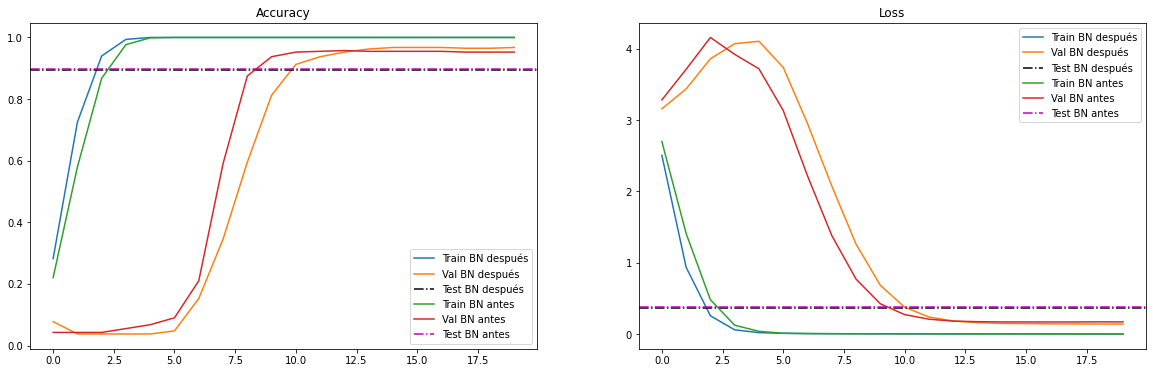

In [ ]:
#Comparación
## Gráficos
plt.rcParams["figure.figsize"] = [20,6]
plt.subplot(1,2,1)
# Red con 1 bloque
plt.plot(history1.history['acc'], label = 'Train BN después')
plt.plot(history1.history['val_acc'], label = 'Val BN después')
plt.axhline(y = acc_tst_2j1[1], color = 'k', linestyle = '-.', label = 'Test BN después')
# Red con 2 bloque
plt.plot(history2.history['acc'], label = 'Train BN antes')
plt.plot(history2.history['val_acc'], label = 'Val BN antes')
plt.axhline(y = acc_tst_2j2[1], color = 'm', linestyle = '-.', label = 'Test BN antes')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
# Red con 1 bloque
plt.plot(history1.history['loss'], label = 'Train BN después')
plt.plot(history1.history['val_loss'], label = 'Val BN después')
plt.axhline(y = acc_tst_2j1[0], color = 'k', linestyle = '-.', label = 'Test BN después')
# Red con 2 bloque
plt.plot(history2.history['loss'], label = 'Train BN antes')
plt.plot(history2.history['val_loss'], label = 'Val BN antes')
plt.axhline(y = acc_tst_2j2[0], color = 'm', linestyle = '-.', label = 'Test BN antes')
plt.legend()
plt.title('Loss')